In [137]:
%matplotlib inline
import numpy as np
import numpy.random as rnd
import SimInterface.functionApproximator as fa
import SimInterface.temporalDifference as td
import SimInterface.kalman as kf
import matplotlib.pyplot as plt
import functools as ft

In [138]:
A = .7
gamma = .8
lam = .7
W = .7
Wrt = np.sqrt(W)

P = W / (1.-A**2.)
Q = 3.


# Approximators

tdQuadApprox = fa.parameterizedQuadratic(NumVars=1,parameter=np.zeros(3))
lstdQuadApprox = fa.parameterizedQuadratic(NumVars=1,parameter=np.zeros(3))
kalmanQuadApprox = fa.parameterizedQuadratic(NumVars=1,parameter=np.zeros(3))

NumBases = 30
Centers = np.reshape(np.linspace(-5,5,NumBases),(NumBases,1))
Lengths = (Centers[1,0] - Centers[0,0])
tdRbfApprox = fa.rbfNetwork(Centers,Lengths,parameter=np.zeros(NumBases))
lstdRbfApprox = fa.rbfNetwork(Centers,Lengths,parameter=np.zeros(NumBases))
kalmanRbfApprox = fa.rbfNetwork(Centers,Lengths,parameter=np.zeros(NumBases))

# TD Operators
tdOperators = []

def stepSizeVariable(k,c,period):
    den = 1 + np.round(k/period)
    return c/den


tdQuad = td.temporalDifferenceLearner(approximator=tdQuadApprox,
                                      discountFactor=gamma,
                                      traceDecayFactor=lam,
                                      stepSize=ft.partial(stepSizeVariable,c=.2,period=5),
                                      label='TD - Quad')
tdOperators.append(tdQuad)

tdRBF = td.temporalDifferenceLearner(approximator=tdRbfApprox,
                                     discountFactor=gamma,
                                     traceDecayFactor=lam,
                                     stepSize=ft.partial(stepSizeVariable,c=.2,period=10),
                                     label='TD - RBF')
# tdOperators.append(tdRBF)

# LSTD Operators
lstdQuad= td.lstdLearner(approximator=lstdQuadApprox,
                         discountFactor=gamma,
                         traceDecayFactor=lam,
                         label='LSTD - Quad')
tdOperators.append(lstdQuad)

lstdRBF = td.lstdLearner(approximator=lstdRbfApprox,
                         discountFactor=gamma,
                         traceDecayFactor=lam,
                         label='LSTD - RBF')
# Not putting in because it is a bit rubbish
# Appears to overfit in data-poor regions. 
# tdOperators.append(lstdRBF)

# Kalman Operators 
kalmanQuad = kf.kalmanPolicyEvaluator(approximator=kalmanQuadApprox,
                                      discountFactor=gamma,
                                      driftCovariance=.1,
                                      measurementCovariance=.5,
                                      priorCovariance=1.,
                                      decay=False,
                                      label='Kalman - Quad')

tdOperators.append(kalmanQuad)

kalmanRBF = kf.kalmanPolicyEvaluator(approximator=kalmanRbfApprox,
                                     discountFactor=gamma,
                                     driftCovariance=.1,
                                     measurementCovariance=.5,
                                     priorCovariance=1.,
                                     decay=False,
                                     label='Kalman - RBF')
# tdOperators.append(kalmanRBF)

# Analytic Solution
S = Q / (1.-gamma*A**2)
c = gamma*S*W/(1.-gamma)

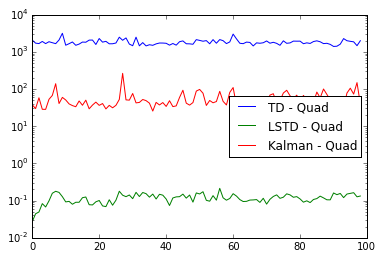

In [144]:
NumSteps = 100
NumRuns = 50

Xtraj = np.zeros(NumSteps)
Xtraj[0] = x

NumOperators = len(tdOperators)
tdErr = np.zeros((NumOperators,NumRuns,NumSteps-1))

for run in range(NumRuns):
    x = np.sqrt(P) * rnd.rand()
    for k in range(NumSteps-1):
        xNew = A*x + Wrt * rnd.randn()
        val = Q * x**2.
        vTrue = S*x**2 + c
        for m in range(NumOperators):
            tdOp = tdOperators[m]
            if isinstance(tdOp,td.lstdLearner):
                tdOp.step(val,x,xNew,updateParameter=True)
            else:
                tdOp.step(val,x,xNew)
            vTD = tdOp.approximator.value(x)
            tdErr[m,run,k] = (vTrue-vTD)**2
        x = xNew
        Xtraj[k+1] = x

line = []
for m in range(NumOperators):
    label = tdOperators[m].label
    tdErrMean = tdErr[m].mean(axis=0)
    handle = plt.semilogy(np.arange(NumSteps-1),tdErrMean,label=label)[0]
    line.append(handle)
plt.legend(handles=line,loc='best')

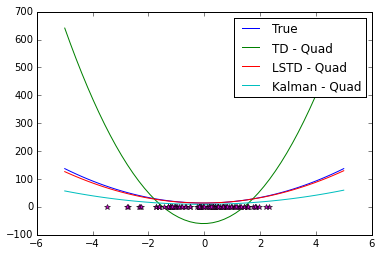

In [140]:
X = np.linspace(-5,5)
Vtrue = S*X**2 + c

line = []
handle = plt.plot(X,Vtrue,label='True')[0]
line.append(handle)
Vtd = np.zeros((NumOperators,len(X)))
for m in range(NumOperators):
    tdOp = tdOperators[m]
    for k in range(len(X)):
        Vtd[m,k] = tdOp.approximator.value(X[k])
    handle = plt.plot(X,Vtd[m],label=tdOp.label)[0]
    line.append(handle)

plt.plot(Xtraj,np.zeros(NumSteps),'*')
plt.legend(handles=line)

In [141]:
type(fun)

function